In [343]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import h5py
from tqdm import tqdm
from scipy.stats import multivariate_normal
from scipy.special import gamma,digamma,gammaln
from scipy.optimize import fminbound
from numpy.linalg import inv, det
from PIL import Image
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Useful Functions

In [239]:
# calculate false positive, false negative and misclassification
def compute_fp_fn_misc(predict_label,y_test):
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    n = len(predict_label)
    for i in range(n): 
        if y_test[i] == predict_label[i] == 1:
            true_positive += 1
        if predict_label[i] == 1 and y_test[i] != predict_label[i]:
            false_positive += 1
        if y_test[i] == predict_label[i] == 0:
            true_negative += 1
        if predict_label[i] == 0 and y_test[i] != predict_label[i]:
            false_negative += 1
    
    false_positive_rate = false_positive/(false_positive+true_negative)
    false_negative_rate = false_negative/(true_positive+false_negative)
    misclassification_rate = (false_positive + false_negative)/n
    
    return false_positive_rate, false_negative_rate, misclassification_rate

In [240]:
# plot ROC curve
def plot_roc_curve(y_test, predict_score, model):
    fpr, tpr, thresholds = roc_curve(y_test, predict_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color="darkorange",
    lw=2, label='ROC curve (area = %0.2f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.savefig(f'./model/{model}/{model}_ROC.png')

In [ ]:
# PCA to reduce feature size
def preprocessing(data, data_size):
    pca = PCA(n_components=data_size)
    pca.fit(data)
    pca_data = pca.transform(data)
    std_scaler = StandardScaler()
    std_scaler.fit(pca_data)
    std_data = std_scaler.transform(pca_data)
    return pca, std_data

## Model 1: Single Gaussian model 

In [15]:
# read train dataset. first 1000 images are face images. 
with h5py.File('./dataset/train_dataset.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_train = data
    y_train = label

# calculate the mean and variance of face images and noface images
# and we have the normal distribution for both classes
face_mean = np.mean(X_train[:1000,:], axis=0)
face_cov_diag = np.diagonal(np.cov(X_train[:1000,:],bias=True, rowvar=False)) # it is the array of the main diagonal entries
face_cov = np.diag(face_cov_diag)

noface_mean = np.mean(X_train[1000:,:], axis=0)
noface_cov_diag = np.diagonal(np.cov(X_train[1000:,:],bias=True, rowvar=False)) # it is the array of the main diagonal entries
noface_cov = np.diag(noface_cov_diag)

# add additional axis to make the array vector form

face_mean = np.expand_dims(face_mean, axis=1)
noface_mean = np.expand_dims(noface_mean, axis=1)

print(face_mean.shape, face_cov.shape)
print(noface_mean.shape, noface_cov.shape)

(1200, 1) (1200, 1200)
(1200, 1) (1200, 1200)


In [33]:
# read test dataset
with h5py.File('./dataset/test_dataset.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_test = data
    y_test = label

X_test = np.expand_dims(X_test, axis=2)
print(X_test.shape)


# from Bayes' rule p(w=1|x) = p(x|w=1)/(p(x|w=1) + p(x|w=0)) and p(w=0) = p(w=1) = 1/2, we calculate log(p(x|w=1)) - log(p(x|w=0))
predict_label = []
predict_score = []
for x in X_test:
    face_likelihood = np.dot(np.dot((x-noface_mean).T,inv(noface_cov)),(x-noface_mean)) - np.dot(np.dot((x-face_mean).T,inv(face_cov)),(x-face_mean)) + np.sum(np.log(noface_cov_diag)) - np.sum(np.log(face_cov_diag))
    pre_label = 1 if face_likelihood > 0 else 0
    predict_label.append(pre_label)
    pre_score = 1/(np.exp(-face_likelihood)+1)
    predict_score.append(pre_score)
    
predict_label = np.array(predict_label).reshape((len(X_test),))
predict_score = np.array(predict_score).reshape((len(X_test),))
print(predict_label)
print(predict_score)

(200, 1200, 1)


C:\Users\hj396\AppData\Local\Temp/ipykernel_26264/4184007270.py:19: RuntimeWarning: overflow encountered in exp
  pre_score = 1/(np.exp(-face_likelihood)+1)


[1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 0
 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0]
[1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.26250231e-172 8.71953784e-304 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 9.62166949e-147 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.22437195e-033 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 0.00000000e+000 1.00000000e+000
 1.00000

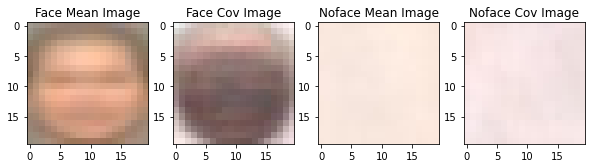

In [6]:
# visualize estimated mean and covariance matrix for face and non-face images
dim = int(np.sqrt(X_test.shape[1]/3)) # 3 represents 3 layers of RGB image
face_mean_image = face_mean.reshape((dim,dim,3)) * 255.0 / np.max(face_mean)
face_cov_image = face_cov_diag.reshape((dim,dim,3)) * 255.0 / np.max(face_cov_diag)
noface_mean_image = noface_mean.reshape((dim,dim,3)) * 255.0 / np.max(noface_mean)
noface_cov_image = noface_cov_diag.reshape((dim,dim,3)) * 255.0 / np.max(noface_cov_diag)

cv2.imwrite('./model/SingleGaussian/face_mean_image.jpg', face_mean_image)
cv2.imwrite('./model/SingleGaussian/face_cov_image.jpg', face_cov_image)

cv2.imwrite('./model/SingleGaussian/noface_mean_image.jpg', noface_mean_image)
cv2.imwrite('./model/SingleGaussian/noface_cov_image.jpg', noface_cov_image)

fig, ax = plt.subplots(1, 4, figsize=(10, 40))
ax[0].imshow(Image.open('./model/SingleGaussian/face_mean_image.jpg'))
ax[0].title.set_text('Face Mean Image')
ax[1].imshow(Image.open('./model/SingleGaussian/face_cov_image.jpg'))
ax[1].title.set_text('Face Cov Image')
ax[2].imshow(Image.open('./model/SingleGaussian/noface_mean_image.jpg'))
ax[2].title.set_text('Noface Mean Image')
ax[3].imshow(Image.open('./model/SingleGaussian/noface_cov_image.jpg'))
ax[3].title.set_text('Noface Cov Image')
plt.show()

In [7]:
false_positive_rate, false_negative_rate, misclassification_rate = compute_fp_fn_misc(predict_label,y_test)

print('False Positive Rate: {}'.format(false_positive_rate))
print('False Negative Rate: {}'.format(false_negative_rate))
print('Misclassification Rate: {}'.format(misclassification_rate))

False Positive Rate: 0.3
False Negative Rate: 0.14
Misclassification Rate: 0.22


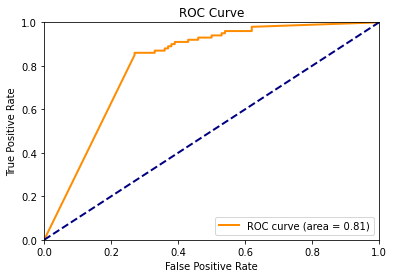

In [34]:
# Plot ROC Curve

plot_roc_curve(y_test, predict_score, 'SingleGaussian')

## Model 2: Mixture of Gaussian Model

Since the feature is 1200 and the dataset size is 1000, directly using multivariate_normal() method leads to singular covariance matrix. We use PCA to decrease the number of features to 100 to reduce the dimension and well define the covariance matrix.

In [450]:
no_component = 5
data_size = 100

In [460]:
# read train dataset. first 1000 images are face images. 
with h5py.File('./dataset/train_dataset.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_train = data
    y_train = label
    
# read test dataset
with h5py.File('./dataset/test_dataset.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_test = data
    y_test = label
    
# # prepocess the data
# pca_train, X_train = preprocessing(X_train, data_size)
# pca_test, X_test = preprocessing(X_test, data_size)
# prepocess the data
pca_train1, X_train1 = preprocessing(X_train[:1000], data_size)
pca_train2, X_train2 = preprocessing(X_train[1000:], data_size)
pca_test, X_test = preprocessing(X_test, data_size)
X_train = np.concatenate((X_train1,X_train2),axis=0)
print(X_train.shape, X_test.shape)

(2000, 100) (200, 100)


In [461]:
from sklearn.mixture import GaussianMixture

# by default we assume 5 components, get the trained mean, covariance matrix of each Gaussian model and weights to these models
gm_face = GaussianMixture(n_components=no_component, random_state=0).fit(X_train[:1000])
face_weights = gm_face.weights_
face_mean = gm_face.means_
face_cov = gm_face.covariances_

gm_noface = GaussianMixture(n_components=no_component, random_state=0).fit(X_train[1000:])
noface_weights = gm_noface.weights_
noface_mean = gm_noface.means_
noface_cov = gm_noface.covariances_

In [462]:
likelihood_f = np.zeros((X_test.shape[0], no_component))
likelihood_nf = np.zeros((X_test.shape[0], no_component))
for i in range(no_component):
    distribution_face = multivariate_normal(
        mean=face_mean[i], 
        cov=face_cov[i], allow_singular=True)
    likelihood_f[:,i] = distribution_face.pdf(X_test)
    
    distribution_noface = multivariate_normal(
        mean=noface_mean[i], 
        cov=noface_cov[i], allow_singular=True)
    likelihood_nf[:,i] = distribution_noface.pdf(X_test)
    
likelihood_face = np.dot(likelihood_f, face_weights)
likelihood_noface = np.dot(likelihood_nf, noface_weights)

In [466]:
predict_label = []
predict_score = []
for i in range(X_test.shape[0]):
    pre_label = 1 if likelihood_face[i] - likelihood_noface[i] < 0 else 0
    predict_label.append(pre_label)
    pre_score = likelihood_noface[i]/(likelihood_face[i] + likelihood_noface[i])
    predict_score.append(pre_score)

In [467]:
false_positive_rate, false_negative_rate, misclassification_rate = compute_fp_fn_misc(predict_label,y_test)

print('False Positive Rate: {}'.format(false_positive_rate))
print('False Negative Rate: {}'.format(false_negative_rate))
print('Misclassification Rate: {}'.format(misclassification_rate))

False Positive Rate: 0.44
False Negative Rate: 0.1
Misclassification Rate: 0.27


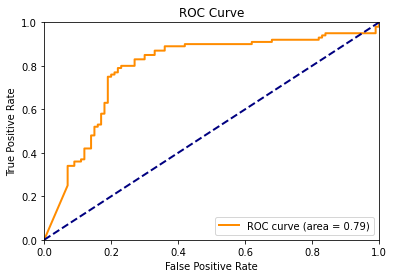

In [468]:
# Plot ROC Curve

plot_roc_curve(y_test, predict_score, 'GaussianMixture')

In [469]:
# visualize estimated mean and covariance matrix for face and non-face images
dim = 20
face_mean_comb = (np.dot(pca_train1.components_.T, np.dot(face_mean.T, face_weights)) + pca_train1.mean_).reshape((dim,dim,3))
face_mean_comb =  face_mean_comb * 255.0 / np.max(face_mean_comb)

face_cov_comb = np.zeros((face_cov.shape[1],face_cov.shape[2]))
for k in range(no_component):
    face_cov_comb += face_cov[k] * face_weights[k]
face_cov_comb = (np.dot(pca_train1.components_.T, np.diagonal(face_cov_comb)) + pca_train1.mean_).reshape((dim,dim,3))
face_cov_comb = face_cov_comb * 255.0 / np.max(face_cov_comb)

noface_mean_comb = (np.dot(pca_train2.components_.T, np.dot(noface_mean.T, noface_weights)) + pca_train2.mean_).reshape((dim,dim,3))
noface_mean_comb =  noface_mean_comb * 255.0 / np.max(noface_mean_comb)

noface_cov_comb = np.zeros((noface_cov.shape[1],noface_cov.shape[2]))
for k in range(no_component):
    noface_cov_comb += noface_cov[k] * noface_weights[k]
noface_cov_comb = (np.dot(pca_train2.components_.T, np.diagonal(noface_cov_comb)) + pca_train2.mean_).reshape((dim,dim,3))
noface_cov_comb = noface_cov_comb * 255.0 / np.max(noface_cov_comb)

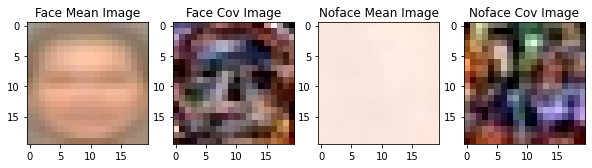

In [470]:
cv2.imwrite('./model/GaussianMixture/face_mean_image.jpg', face_mean_comb)
cv2.imwrite('./model/GaussianMixture/face_cov_image.jpg', face_cov_comb)

cv2.imwrite('./model/GaussianMixture/noface_mean_image.jpg', noface_mean_comb)
cv2.imwrite('./model/GaussianMixture/noface_cov_image.jpg', noface_cov_comb)

fig, ax = plt.subplots(1, 4, figsize=(10, 40))
ax[0].imshow(Image.open('./model/GaussianMixture/face_mean_image.jpg'))
ax[0].title.set_text('Face Mean Image')
ax[1].imshow(Image.open('./model/GaussianMixture/face_cov_image.jpg'))
ax[1].title.set_text('Face Cov Image')
ax[2].imshow(Image.open('./model/GaussianMixture/noface_mean_image.jpg'))
ax[2].title.set_text('Noface Mean Image')
ax[3].imshow(Image.open('./model/GaussianMixture/noface_cov_image.jpg'))
ax[3].title.set_text('Noface Cov Image')
plt.show()

## Model 3: T-distribution Model

In [523]:
data_size = 100

# read train dataset. first 1000 images are face images. 
with h5py.File('./dataset/train_dataset.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_train = data
    y_train = label
    
# read test dataset
with h5py.File('./dataset/test_dataset.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_test = data
    y_test = label
    
# prepocess the data
pca_train1, X_train1 = preprocessing(X_train[:1000], data_size)
pca_train2, X_train2 = preprocessing(X_train[1000:], data_size)
pca_test, X_test = preprocessing(X_test, data_size)
X_train = np.concatenate((X_train1,X_train2),axis=0)
print(X_train.shape, X_test.shape)

(2000, 100) (200, 100)


In [477]:
def loss_func(v, e_h, e_logh, dim, cov, mean, data):
    length = len(e_h)
    sum = 0
    for i in range(length):
        temp = np.dot(np.dot((data[i,:]-mean).T, inv(cov)), (data[i,:]-mean)) * e_h[i]
        term1 = 0.5 * (dim * e_logh[i] - dim * np.log(2*np.pi) - np.log(det(cov)) - temp)
        term2 = (v/2) * np.log((v/2)) - gammaln((v/2)) + ((v/2) - 1) * e_logh[i] - (v/2) * e_h[i]
        sum = sum + term1 + term2
    sum = -sum
    return sum

In [478]:
class T_distribution():
    def __init__(self, data, mean, cov, v):
        self.data = data
        self.data_size = self.data.shape[0]
        self.dimensions = self.data.shape[1]
        self.mean = mean
        self.cov = cov
        self.v = v
        self.e_h = np.zeros(self.data_size)
        self.e_logh = np.zeros(self.data_size)
        
    def update_v(self):
        v = fminbound(loss_func, 0, 20, args=(self.e_h, self.e_logh, self.dimensions, self.cov, self.mean, self.data)) 
        return v
        
    def EM(self):
        
        # E-step
        for col in range(self.data_size): 
            temp = np.dot(np.dot((self.data[col,:]-self.mean).T, inv(self.cov)), (self.data[col,:]-self.mean))
            self.e_h[col] = (self.v+self.dimensions) /(self.v+temp)
            self.e_logh[col] = digamma((self.v+self.dimensions)/2) - np.log((self.v+temp)/2)
        
        # M-step
        self.mean = np.sum(np.dot(np.diag(self.e_h), self.data), axis=0)/np.sum(self.e_h)
        
        numerator = np.zeros((self.dimensions, self.dimensions))
        for col in range(self.data_size):
            temp = np.outer((self.data[col,:]-self.mean), (self.data[col,:]-self.mean))
            numerator += self.e_h[col]*temp
        self.cov = numerator/np.sum(self.e_h)
        self.cov = np.diag(np.diagonal(self.cov))
        self.v = self.update_v()
            
    def predict(self, data, col):
        term1 = gamma((self.v + self.dimensions)/2) / (((self.v * np.pi)** self.dimensions/2) *np.sqrt(det(self.cov))*gamma(self.v/2))                                
        term2 = np.dot(np.dot((data[col,:]-self.mean).T,inv(self.cov)), (data[col,:] - self.mean))
        term = (1 + term2/self.v)
        prob = term1 * pow(term, -(self.v+self.dimensions)/2)
        return prob
        

In [479]:
face_mean = np.mean(X_train[:1000], axis=0)
face_cov = np.diag(np.diagonal(np.cov(X_train[:1000],bias=True, rowvar=False)))
noface_mean = np.mean(X_train[1000:], axis=0)
noface_cov = np.diag(np.diagonal(np.cov(X_train[1000:],bias=True, rowvar=False)))
print(face_mean.shape,face_cov.shape,noface_mean.shape,noface_cov.shape)

(100,) (100, 100) (100,) (100, 100)


In [480]:
iteration = 100

t_dist_face = T_distribution(X_train[:1000], face_mean, face_cov, v=2)
t_dist_noface = T_distribution(X_train[1000:], noface_mean, noface_cov, v=2)

for i in tqdm(range(iteration)):
    t_dist_face.EM()
    t_dist_noface.EM()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [15:49<00:00,  9.49s/it]


In [524]:
predict_label = []
predict_score = []
for i in range(X_test.shape[0]):
    pre_label = 1 if t_dist_face.predict(X_test,i) - t_dist_noface.predict(X_test,i) > 0 else 0
    predict_label.append(pre_label)
    pre_score = t_dist_face.predict(X_test,i) /(t_dist_face.predict(X_test,i) + t_dist_noface.predict(X_test,i))
    predict_score.append(pre_score)


In [525]:
false_positive_rate, false_negative_rate, misclassification_rate = compute_fp_fn_misc(predict_label,y_test)

print('False Positive Rate: {}'.format(false_positive_rate))
print('False Negative Rate: {}'.format(false_negative_rate))
print('Misclassification Rate: {}'.format(misclassification_rate))

False Positive Rate: 0.0
False Negative Rate: 1.0
Misclassification Rate: 0.5


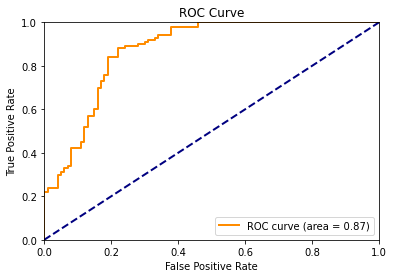

In [526]:
# Plot ROC Curve

plot_roc_curve(y_test, predict_score, 't-Distribution')

In [484]:
face_mean = t_dist_face.mean
face_cov = t_dist_face.cov
noface_mean = t_dist_noface.mean
noface_cov = t_dist_noface.cov

# visualize estimated mean and covariance matrix for face and non-face images
dim = 20
face_mean_comb = (np.dot(pca_train1.components_.T, face_mean) + pca_train1.mean_).reshape((dim,dim,3))
face_mean_comb =  face_mean_comb * 255.0 / np.max(face_mean_comb)

face_cov_comb = (np.dot(pca_train1.components_.T, np.diagonal(face_cov)) + pca_train1.mean_).reshape((dim,dim,3))
face_cov_comb = face_cov_comb * 255.0 / np.max(face_cov_comb)

noface_mean_comb = (np.dot(pca_train2.components_.T, noface_mean) + pca_train2.mean_).reshape((dim,dim,3))
noface_mean_comb =  noface_mean_comb * 255.0 / np.max(noface_mean_comb)

noface_cov_comb = (np.dot(pca_train2.components_.T, np.diagonal(noface_cov)) + pca_train2.mean_).reshape((dim,dim,3))
noface_cov_comb = noface_cov_comb * 255.0 / np.max(noface_cov_comb)

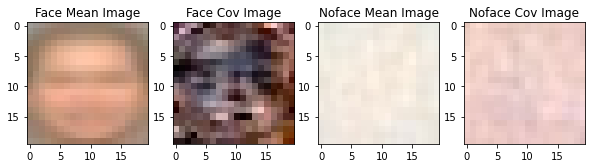

In [485]:
cv2.imwrite('./model/t-Distribution/face_mean_image.jpg', face_mean_comb)
cv2.imwrite('./model/t-Distribution/face_cov_image.jpg', face_cov_comb)

cv2.imwrite('./model/t-Distribution/noface_mean_image.jpg', noface_mean_comb)
cv2.imwrite('./model/t-Distribution/noface_cov_image.jpg', noface_cov_comb)

fig, ax = plt.subplots(1, 4, figsize=(10, 40))
ax[0].imshow(Image.open('./model/t-Distribution/face_mean_image.jpg'))
ax[0].title.set_text('Face Mean Image')
ax[1].imshow(Image.open('./model/t-Distribution/face_cov_image.jpg'))
ax[1].title.set_text('Face Cov Image')
ax[2].imshow(Image.open('./model/t-Distribution/noface_mean_image.jpg'))
ax[2].title.set_text('Noface Mean Image')
ax[3].imshow(Image.open('./model/t-Distribution/noface_cov_image.jpg'))
ax[3].title.set_text('Noface Cov Image')
plt.show()

## Model 4: Factor Analyzer

In [506]:
data_size = 100

# read train dataset. first 1000 images are face images. 
with h5py.File('./dataset/train_dataset.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_train = data
    y_train = label
    
# read test dataset
with h5py.File('./dataset/test_dataset.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_test = data
    y_test = label
    
# prepocess the data
pca_train, X_train = preprocessing(X_train, data_size)
pca_test, X_test = preprocessing(X_test, data_size)
print(X_train.shape, X_test.shape)

(2000, 100) (200, 100)


In [507]:
class FactorAnalyzer():
    def __init__(self, data, mean, cov, phi, k):
        self.data = data
        self.data_size = self.data.shape[0]
        self.dimensions = self.data.shape[1]
        self.mean = mean
        self.cov = cov
        self.phi = phi
        self.K = k
        
        self.e_h = np.zeros((self.data_size, self.K,))
        self.e_hh_t = np.zeros((self.data_size, self.K, self.K,))
        
    def EM(self):  
        
        # E-step
        term1 = inv(np.dot(np.dot(self.phi.T, inv(self.cov)), self.phi) + np.eye(self.K)) 
        term2 = np.dot(np.dot(term1, self.phi.T), inv(self.cov))
        for i in range(self.data_size):
            self.e_h[i] = np.dot(term2, self.data[i,:]-self.mean)
            self.e_hh_t[i] = term1 + np.outer(self.e_h[i], self.e_h[i])
            
        # M-step        
        term1 = np.zeros((self.dimensions, self.K))
        term2 = np.zeros((self.K, self.K))
        for i in range(self.data_size):
            term1 += np.outer((self.data[i,:]-self.mean), self.e_h[i])
            term2 += self.e_hh_t[i]
        self.phi = np.dot(term1, inv(term2))
        
        term = np.zeros((self.dimensions, self.dimensions))
        for i in range(self.data_size):
            term += np.outer(self.data[i,:]-self.mean, self.data[i,:]-self.mean) 
            temp = np.outer(np.dot(self.phi, self.e_h[i]), self.data[i,:] - self.mean)
            term = term - temp
        term = term/self.data_size
        self.cov = np.diag(np.diagonal(term))               
            
    def predict(self, data, col):
        cov = np.dot(self.phi, self.phi.T) + self.cov
        term = -0.5 * np.dot(np.dot((data[col,:] - self.mean).T,inv(cov)), (data[col,:] - self.mean))
        pdf =  np.exp(term) / (np.sqrt(abs(det(cov))) * ((2 * np.pi) ** (self.dimensions/2)))
        return pdf

In [508]:
face_mean = np.mean(X_train[:1000], axis=0)
face_cov = np.diag(np.diagonal(np.cov(X_train[:1000],bias=True, rowvar=False)))
noface_mean = np.mean(X_train[1000:], axis=0)
noface_cov = np.diag(np.diagonal(np.cov(X_train[1000:],bias=True, rowvar=False)))
print(face_mean.shape,face_cov.shape,noface_mean.shape,noface_cov.shape)

(100,) (100, 100) (100,) (100, 100)


In [509]:
# choose the number of factors
K = 50
face_phi = np.random.rand(data_size, K)
noface_phi = np.random.rand(data_size, K)

face_fa = FactorAnalyzer(X_train[:1000], face_mean, face_cov, face_phi, K)
noface_fa = FactorAnalyzer(X_train[1000:], noface_mean, noface_cov, noface_phi, K)

In [510]:
iterations = 5
for i in tqdm(range(iterations)):
    face_fa.EM()
    noface_fa.EM()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]


In [516]:
face_mean = face_fa.mean
face_cov_temp = face_fa.cov
face_phi = face_fa.phi
face_cov = np.dot(face_phi,face_phi.T) + face_cov_temp

noface_mean = noface_fa.mean
noface_cov_temp = noface_fa.cov
noface_phi = noface_fa.phi
noface_cov = np.dot(noface_phi,noface_phi.T) + noface_cov_temp

# visualize estimated mean and covariance matrix for face and non-face images
dim = 20
face_mean_comb = (np.dot(pca_train.components_.T, face_mean) + pca_train.mean_).reshape((dim,dim,3))
face_mean_comb =  face_mean_comb * 255.0 / np.max(face_mean_comb)

face_cov_comb = (np.dot(pca_train.components_.T, np.diagonal(face_cov)) + pca_train.mean_).reshape((dim,dim,3))
face_cov_comb = face_cov_comb * 255.0 / np.max(face_cov_comb)

noface_mean_comb = (np.dot(pca_train.components_.T, noface_mean) + pca_train.mean_).reshape((dim,dim,3))
noface_mean_comb =  noface_mean_comb * 255.0 / np.max(noface_mean_comb)

noface_cov_comb = (np.dot(pca_train.components_.T, np.diagonal(noface_cov)) + pca_train.mean_).reshape((dim,dim,3))
noface_cov_comb = noface_cov_comb * 255.0 / np.max(noface_cov_comb)

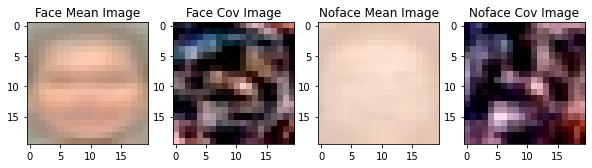

In [517]:
cv2.imwrite('./model/FactorAnalyzer/face_mean_image.jpg', face_mean_comb)
cv2.imwrite('./model/FactorAnalyzer/face_cov_image.jpg', face_cov_comb)

cv2.imwrite('./model/FactorAnalyzer/noface_mean_image.jpg', noface_mean_comb)
cv2.imwrite('./model/FactorAnalyzer/noface_cov_image.jpg', noface_cov_comb)

fig, ax = plt.subplots(1, 4, figsize=(10, 40))
ax[0].imshow(Image.open('./model/FactorAnalyzer/face_mean_image.jpg'))
ax[0].title.set_text('Face Mean Image')
ax[1].imshow(Image.open('./model/FactorAnalyzer/face_cov_image.jpg'))
ax[1].title.set_text('Face Cov Image')
ax[2].imshow(Image.open('./model/FactorAnalyzer/noface_mean_image.jpg'))
ax[2].title.set_text('Noface Mean Image')
ax[3].imshow(Image.open('./model/FactorAnalyzer/noface_cov_image.jpg'))
ax[3].title.set_text('Noface Cov Image')
plt.show()

In [513]:
predict_label = []
predict_score = []
for i in range(X_test.shape[0]):
    pre_label = 1 if face_fa.predict(X_test,i) - noface_fa.predict(X_test,i) > 0 else 0
    predict_label.append(pre_label)
    pre_score = face_fa.predict(X_test,i) /(face_fa.predict(X_test,i) + noface_fa.predict(X_test,i))
    predict_score.append(pre_score)

In [514]:
false_positive_rate, false_negative_rate, misclassification_rate = compute_fp_fn_misc(predict_label,y_test)

print('False Positive Rate: {}'.format(false_positive_rate))
print('False Negative Rate: {}'.format(false_negative_rate))
print('Misclassification Rate: {}'.format(misclassification_rate))

False Positive Rate: 0.36
False Negative Rate: 0.04
Misclassification Rate: 0.2


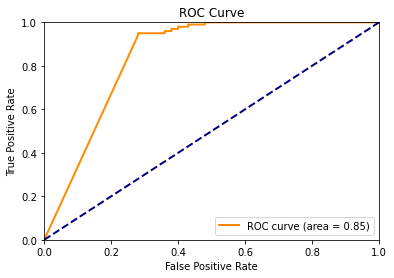

In [515]:
# Plot ROC Curve

plot_roc_curve(y_test, predict_score, 'FactorAnalyzer')